In [79]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from matplotlib import cm
plt.rcParams['font.size'] = 13
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False

###  Useful functions definitions

In [118]:
# Useful function definitions, explained throughout the text below

# Poisson regression canonical inverse link function
#invLinkFun = lambda X, w: np.exp(np.dot(X, w))

# Poisson regression rectified inverse link function
def invLinkFun(X, w):
    z = np.dot(X, w)
    mu = np.zeros(z.shape)
    mu[z<0] = np.exp(z[z<0])
    mu[z>=0] = z[z>=0] + 1
    return mu

# Poisson regression log-likelihood
logLikFun = lambda X, w, y: np.sum(y*np.log(invLinkFun(X, w))-invLinkFun(X, w))
# Poisson regression negative log-likelihood
negLogLikFun = lambda X, w, y: np.sum(invLinkFun(X, w) - y*np.log(invLinkFun(X, w)))

# Get n grayscale colors
def getGrayColors(n):
    colors = [];
    for i in range(1, n+1):
        colors.append(i/(n+1.)*np.ones(3))
    return colors

### Example case 

Suppose we have observed spike responses $y$ to some one-dimensional stimulus $x$. Furthermore, suppose that the cell exhibited some thresholding mechanins: hardly any spikes were observed for stimulus values below a certain threshold, whereas the response grew roughly linearly above the threshold. In such a schenario, the data might look something like the example below. We would finally like to describe the cell's stimulus response mapping using a simple model, and one alternative is a soft-rectifying function:
\begin{equation}
 \hat{y} = f(z) = 
 \begin{cases}
  \exp(z),& \text{if  } z \leq 0\\
  z + 1,& \text{if  } z > 0\\
 \end{cases}
\end{equation}
where $\hat{y}$ is the predicted putput, $z=w_0+w_1x$, $w_0$ the threshold, and $w_1$ the slope.

In [98]:
# Parameters
n = 200;
wTrue = [-1, 0.5]

# Generate example data
x = np.random.rand(n)*30 - 15
x = np.sort(x)
X = np.vstack([-np.ones(n), x]).T
mu = invLinkFun(X, wTrue)
y = np.random.poisson(mu)

# Callback plotting function for interactive plots
def plot_fun(x, y, w0, w1):
    fig = plt.figure(figsize=(7.5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y, 'k.', label='data')
    wTmp = np.array([w0, w1])
    muTmp = invLinkFun(X, wTmp)
    ax.plot(x, muTmp, '-', color=0.5*np.ones(3))
    ax.set_ylabel('Spike count')
    ax.set_xlabel('x')
    ax.set_xticks([-10, 0, 10]);
    ax.set_ylim([-1, 11]);

interact(plot_fun, x=fixed(x), y=fixed(y), w0=(-5., 5.), w1=(-5., 5.));

interactive(children=(FloatSlider(value=0.0, description='w0', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

### Objective functions

A manual search for good parameter values can be quite tricky and cumbersome, especially if there are more than just two model parameters. An automatic way would be a lot simpler, but for that we need some measure of how "good" a specific selection of model parameters are. One natural way of quantifying "goodness" is through a likelihood function, which states how likely it is for you to observe the current data given some model parameters. For example, if we assume that the observed spike counts come from a Poisson distribution whose mean is given by our soft-rectifying function, then the likelihood $l$ for any parameters is given by:
\begin{equation}
 l(w_0, w_1) = \prod_i^N \frac{f(z_i)^{y_i} \exp(-f(z_i))}{y_i!}.
\end{equation}
The log of this likelihood function, the log-likelihood $ll$, is usually easier to deal with, and it is given by:
\begin{equation}
 ll(w_0, w_1) = \sum_i^N y_i\log(f(z_i)) -f(z_i) -\log(y_i!).
\end{equation}
Finally, we note that the last term can be ignored (it does not depend on our model parameters), whereupon we are left with:
\begin{equation}
 ll(w_0, w_1) = \sum_i^N y_i\log(f(z_i)) -f(z_i).
\end{equation}

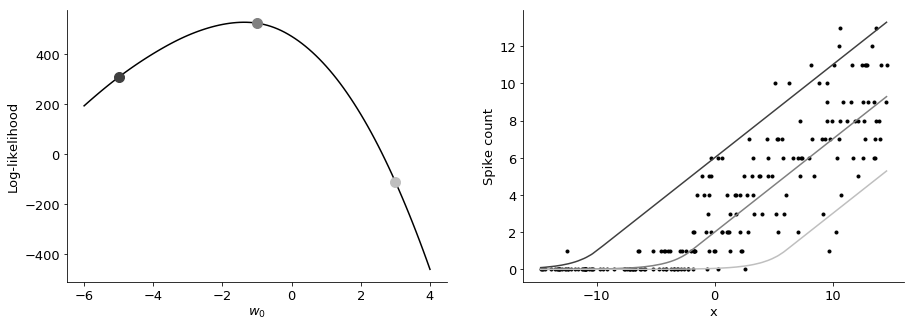

In [105]:
# Example parameters
w0Ex = np.array([wTrue[0]-4, wTrue[0], wTrue[0]+4])
w0Vals = np.linspace(wTrue[0]-5, wTrue[0]+5, 101)

# Negative log-likelihood function
nll = []
for w0 in w0Vals:
    wTmp = np.array([w0, wTrue[1]])
    nll.append(logLikFun(X, wTmp, y))

# Negative log-likelihood values for our example parameters
nllEx = []
for w0 in w0Ex:
    wTmp = np.array([w0, wTrue[1]])
    nllEx.append(logLikFun(X, wTmp, y))

# Plotting
grayColors = getGrayColors(3)
fig = plt.figure(figsize=(15, 5))
# Negative log-likelihoods first
ax = fig.add_subplot(1, 2, 1)
ax.plot(w0Vals, nll, 'k-')
for i in range(w0Ex.size):
    ax.plot(w0Ex[i], nllEx[i], 'o', ms=10, color=grayColors[i])
ax.set_xlabel('$w_0$')
ax.set_ylabel('Log-likelihood')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x, y, 'k.', label='data')
for i in range(w0Ex.size):
    wTmp = np.array([w0Ex[i], wTrue[1]])
    pTmp = invLinkFun(X, wTmp)
    ax.plot(x, pTmp, '-', color=grayColors[i])
ax.set_ylabel('Spike count')
ax.set_xlabel('x')
ax.set_xticks([-10, 0, 10]);

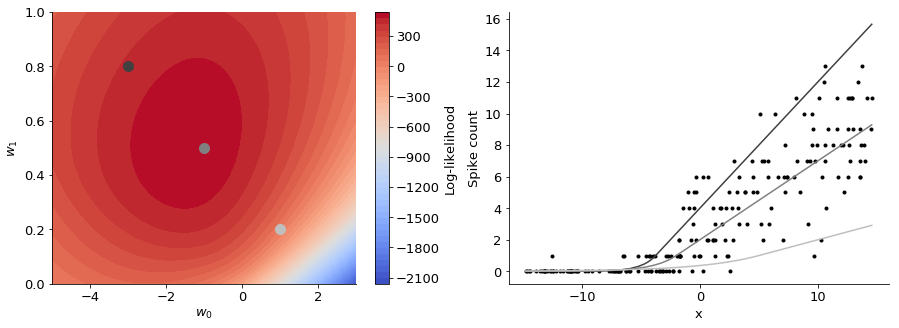

In [117]:
wEx = np.array([[wTrue[0]-2, wTrue[0], wTrue[0]+2], [wTrue[1]+0.3, wTrue[1], wTrue[1]-0.3]])

# Get w0 and w1 combinations over a grid
nGrid = 41
W0, W1 = np.meshgrid(np.linspace(wTrue[0]-4, wTrue[0]+4, nGrid), np.linspace(wTrue[1]-0.5, wTrue[1]+0.5, nGrid))

# Get the MSE for each combination
nllVals = np.zeros([nGrid, nGrid])
for i in range(nGrid):
    for j in range(nGrid):
        wTmp = np.array([W0[i, j], W1[i, j]])
        nllVals[i, j] = logLikFun(X, wTmp, y)
    
nllEx = []
for i in range(3):
    wTmp = wEx[:, i]
    nllEx.append(logLikFun(X, wTmp, y))

# Plot the surface
grayColors = getGrayColors(3)
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
contourHandle = ax.contourf(W0, W1, nllVals, 50, cmap=cm.coolwarm)
for i in range(wEx.shape[1]):
    ax.plot(wEx[0, i], wEx[1, i], 'o', ms=10, color=grayColors[i])
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$');
cBarHandle = plt.colorbar(contourHandle)
cBarHandle.set_label('Log-likelihood')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x, y, 'k.', label='data')
for i in range(wEx.shape[1]):
    wTmp = wEx[:, i]
    pTmp = invLinkFun(X, wTmp)
    ax.plot(x, pTmp, '-', color=grayColors[i])
ax.set_ylabel('Spike count')
ax.set_xlabel('x')
ax.set_xticks([-10, 0, 10]);

### First order methods

### Second order methods